#**Statistical validation tests: gauges, CHIRPS and IMERG.**

Script used for statistical validation tests of daily rainfall data from gauges, CHIRPS and IMERG.

Area of Study: The Paraiba's Valley and North Coast of the Sao Paulo state, Brazil.

Time series: from 2000-06-01 to 2018-12-31.



## Mount drive for accessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing and importing libs

In [ ]:
!pip install hydrobr  # for the brazilian rainfall data network 
import hydrobr

!pip install HydroErr
import HydroErr as he

!pip install shapely #==1.8a3 -q
!pip install geopandas
!pip install pygeos
!pip install rtree
!pip install pandas==1.3.3

import matplotlib.pyplot as plt  #needed to plot maps
import geopandas as gpd  #needed to read shapefiles
import pygeos #needed for geopandas
import rtree #needed for geopandas
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

print(pd.__version__) # Get pandas Version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 14.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


## Starting with the gauges data download using Hydrobr package

In [ ]:
# To get the list of prec stations
list_stations = hydrobr.get_data.ANA.list_prec_stations() 
# To show the first five rows of the data
list_stations.head()

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
0,SALINÓPOLIS,00047000,2,32,SALINÓPOLIS,PARÁ,INMET,-0.6500,-47.5500,1958/01/01,1964/12/31,7,25.0,0,100.0
1,SALINÓPOLIS,00047002,2,32,SALINÓPOLIS,PARÁ,ANA,-0.6231,-47.3536,1977/12/09,2019/08/31,43,3.5,35,18.6
2,CURUÇA,00047003,2,32,CURUÇA,PARÁ,ANA,-0.7375,-47.8536,1981/07/01,2019/07/31,39,2.4,29,25.6
3,PRIMAVERA,00047004,2,32,PRIMAVERA,PARÁ,ANA,-0.9294,-47.0994,1982/02/18,2019/08/31,38,0.0,35,7.9
4,MARUDA,00047005,2,32,MARAPANIM,PARÁ,ANA,-0.6336,-47.6583,1989/08/21,2019/07/31,31,5.0,20,35.5


In [ ]:
# filtering by cities name

cities = ['APARECIDA', 'ARAPEÍ', 'AREIAS', 'BANANAL', 'CAÇAPAVA', 'CACHOEIRA PAULISTA', 'CAMPOS DO JORDÃO', 'CANAS', 'CARAGUATATUBA', 'CRUZEIRO', 'CUNHA', 'GUARATINGUETÁ', 'IGARATA', 'ILHABELA', 'JACAREÍ', 'JAMBEIRO', 'LAGOINHA', 'LAVRINHAS', 'LORENA', 'MONTEIRO LOBATO', 'NATIVIDADE DA SERRA', 'PARAIBUNA', 'PINDAMONHANGABA', 'PIQUETE', 'POTIM', 'QUELUZ', 'REDENÇÃO DA SERRA', 'ROSEIRA', 'SANTA BRANCA', 'SANTO ANTÔNIO DO PINHAL', 'SÃO BENTO DO SAPUCAÍ', 'SÃO JOSÉ DO BARREIRO', 'SÃO JOSÉ DOS CAMPOS', 'SÃO LUIZ DO PARAITINGA', 'SÃO SEBASTIÃO', 'SILVEIRAS', 'TAUBATÉ', 'TREMEMBÉ', 'UBATUBA']
list_stations = list_stations[list_stations['City'].isin(cities)]
list_stations

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
8156,QUELUZ,02244001,2,58,QUELUZ,SÃO PAULO,ANA,-22.5406,-44.7736,1943/01/01,2019/08/31,77,7.7,63,18.2
8157,QUELUZ,02244002,2,58,QUELUZ,SÃO PAULO,DAEE-SP,-22.5333,-44.7667,1956/01/01,1995/11/28,40,2.9,36,10.0
8158,CRUZEIRO,02244003,2,58,CRUZEIRO,SÃO PAULO,ANA,-22.5892,-44.9558,1934/01/01,2004/06/30,71,13.1,52,26.8
8159,CRUZEIRO,02244004,2,58,CRUZEIRO,SÃO PAULO,LIGHT,-22.5814,-44.9650,1929/05/26,2004/01/20,76,0.6,59,22.4
8160,CRUZEIRO,02244005,2,58,CRUZEIRO,SÃO PAULO,DAEE-SP,-22.5833,-44.9833,1937/06/01,2000/11/30,64,4.3,49,23.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207,BAIRRO REMEDINHO,02346016,2,58,JACAREÍ,SÃO PAULO,DAEE-SP,-23.2333,-46.0167,1961/01/02,1973/01/31,13,0.2,11,15.4
9309,JUNDIAÍ,02346156,2,62,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,EMAE,-23.2000,-46.8833,1928/01/01,1986/06/30,59,3.3,45,23.7
9319,NOVA IGARATA,02346166,2,58,IGARATA,SÃO PAULO,LIGHT,-23.2042,-46.1569,1965/04/01,1980/12/31,16,6.4,11,31.2
9412,USINA DO TURVO,02346270,2,58,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,LIGHT,-23.0975,-46.0189,1937/07/01,1960/12/31,24,0.7,21,12.5


In [ ]:
# set StartDate and EndDate as datetime format to filter by date
list_stations['StartDate']= pd.to_datetime(list_stations['StartDate'])
list_stations['EndDate']= pd.to_datetime(list_stations['EndDate'])
 
# Check the format of 'Date' column
list_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 8156 to 9468
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Name         285 non-null    object        
 1   Code         285 non-null    object        
 2   Type         285 non-null    int64         
 3   SubBasin     285 non-null    int64         
 4   City         285 non-null    object        
 5   State        285 non-null    object        
 6   Responsible  285 non-null    object        
 7   Latitude     285 non-null    float64       
 8   Longitude    285 non-null    float64       
 9   StartDate    285 non-null    datetime64[ns]
 10  EndDate      285 non-null    datetime64[ns]
 11  NYD          285 non-null    int64         
 12  MD           285 non-null    float64       
 13  N_YWOMD      285 non-null    int64         
 14  YWMD         285 non-null    float64       
dtypes: datetime64[ns](2), float64(4), int64(4), object(5)

In [ ]:
#filter list_stations by date
list_stations = list_stations[(list_stations['EndDate'] >= '2000-01-01')]
list_stations

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
8156,QUELUZ,02244001,2,58,QUELUZ,SÃO PAULO,ANA,-22.5406,-44.7736,1943-01-01,2019-08-31,77,7.7,63,18.2
8158,CRUZEIRO,02244003,2,58,CRUZEIRO,SÃO PAULO,ANA,-22.5892,-44.9558,1934-01-01,2004-06-30,71,13.1,52,26.8
8159,CRUZEIRO,02244004,2,58,CRUZEIRO,SÃO PAULO,LIGHT,-22.5814,-44.9650,1929-05-26,2004-01-20,76,0.6,59,22.4
8160,CRUZEIRO,02244005,2,58,CRUZEIRO,SÃO PAULO,DAEE-SP,-22.5833,-44.9833,1937-06-01,2000-11-30,64,4.3,49,23.4
8162,SILVEIRAS,02244007,2,58,SILVEIRAS,SÃO PAULO,DAEE-SP,-22.6667,-44.8500,1969-08-01,2014-11-30,46,13.0,33,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9189,UHE SANTA BRANCA JACAREÍ,02345203,2,58,JACAREÍ,SÃO PAULO,LIGHT,-23.3106,-45.9711,2002-10-01,2012-12-31,11,7.0,1,90.9
9190,JACAREÍ,02345204,2,58,JACAREÍ,SÃO PAULO,ANA,-23.3103,-45.9681,2006-06-07,2019-10-31,14,5.1,8,42.9
9191,PARQUE MOÇOTA,02345210,2,58,CAÇAPAVA,SÃO PAULO,ANA,-23.0781,-45.7111,2005-09-20,2007-11-30,3,0.0,1,66.7
9197,REPRESA (MONTE CLARO),02346006,2,58,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,DAEE-SP,-23.1000,-46.0333,1969-09-01,2004-03-31,36,11.4,23,36.1


In [ ]:
# code column to list

codes = list_stations['Code'].tolist()

In [ ]:
# getting the gauges data
data = hydrobr.get_data.ANA.prec_data(codes)
data

100%|██████████| 104/104 [05:48<00:00,  3.35s/it]


,02244001,02244003,02244004,02244005,02244007,02244010,02244012,02244025,02244026,02244048,...,02345164,02345172,02345176,02345191,02345202,02345203,02345204,02345210,02346006,02346344
1927-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# filtering by data one more time to define the time series

data = data['2000-06-01' : '2018-12-31']
data

,02244001,02244003,02244004,02244005,02244007,02244010,02244012,02244025,02244026,02244048,...,02345164,02345172,02345176,02345191,02345202,02345203,02345204,02345210,02346006,02346344
2000-06-01,0.4,NaN,0.0,0.0,0.0,0.0,0.3,0.5,NaN,0.0,...,0.2,0.6,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.5
2000-06-02,3.5,NaN,0.0,0.0,2.3,0.0,1.5,0.0,NaN,0.0,...,0.0,1.1,0.9,0.0,NaN,NaN,NaN,NaN,2.4,0.3
2000-06-03,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,5.6,NaN,NaN,NaN,NaN,0.0,0.0
2000-06-04,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,4.0,1.5,NaN,NaN,NaN,NaN,0.0,0.0
2000-06-05,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.1,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2.6,NaN,NaN,NaN,2.8,18.7,NaN,NaN,NaN,6.8,...,0.0,NaN,12.6,0.0,NaN,NaN,NaN,NaN,NaN,2.1
2018-12-28,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,16.8,...,0.0,NaN,12.9,0.4,NaN,NaN,NaN,NaN,NaN,0.0
2018-12-29,0.4,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2.1,...,14.2,NaN,0.0,33.4,NaN,NaN,NaN,NaN,NaN,5.4
2018-12-30,2.6,NaN,NaN,NaN,18.7,0.0,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# filtering by percentage of NANs
# exporting to .csv

perc = 30 # Like N %
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
dataP = data.dropna( axis=1, thresh=min_count)
dataP.to_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')

In [ ]:
# checking the quantity of NAN values

print(dataP.isnull().sum())

In [ ]:
# getting the code list of stations in the columns

codes = list(dataP.columns)
codes

##Data pre-processing 

In [ ]:
# Grouping daily gauge data into 2 and 3 days for each gauge
gauges = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauges = gauges[['Unnamed: 0', '02244001', '02344012', '02344009', '02345191', '02245010', '02245018', '02345058', '02245020', '02244010', '02345008', '02345164', '02345071', '02345062', '02245054', '02345034', '02345161', '02346344', '02345032', '02345023', '02345057', '02244048']]
gauges['Unnamed: 0'] =  pd.to_datetime(gauges['Unnamed: 0'])
gauges = gauges.set_index('Unnamed: 0')

for column in gauges:
  gaugesdays = gauges.groupby(pd.Grouper(axis=0, 
                      freq='2d', sort=True, dropna=False), dropna=False).apply(lambda g: g.sum(skipna=False)) # change the freq for more days

# exporting df to .csv
gaugesdays.to_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges2d.csv') # change the file name for the file with more days grouped

In [ ]:
# Grouping daily satellite data into 2 and 3 days for each gauge
## satellites data were downloaded from Google Earth Engine and saved as .csv file
## same points as the gauges were used to download satellites data

sat = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv')
sat = sat[['date', '2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']]
sat['date'] = pd.to_datetime(sat['date'])
sat = sat.set_index('date')

for column in sat:
  sat2d = sat.groupby(pd.Grouper(axis=0, 
                      freq='2d', sort=True), dropna=False).sum()

# exporting df to .csv
sat2d.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/days/chirps2d.csv') # change the file name for the file with more days grouped

#IMERG data & gauges validation statistics

In [ ]:
# Calculating Pearson Coeficient: df.corrwith()
# exporting df to .csv


imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/days/imerg2d.csv').set_index('Data')
#imerg.info()

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges2d.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

imerg.corrwith(stations).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/pearsonIMERG2d.csv')

In [ ]:
# IMERG Pearson & p-value


import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = stations.join(imerg, rsuffix='i')

df_dict = {c:df[[c, c+'i']] for c in codes}

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  rho = df_dict[c].corr()
  pval = df_dict[c].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))
  r = rho.round(2).astype(str) + p
  print(r)#.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/p-value-IMERG1d.csv')

         2244001 2244001i
2244001     1.0*    0.35*
2244001i   0.35*     1.0*
         2344012 2344012i
2344012     1.0*    0.33*
2344012i   0.33*     1.0*
         2344009 2344009i
2344009     1.0*    0.31*
2344009i   0.31*     1.0*
         2345191 2345191i
2345191     1.0*    0.19*
2345191i   0.19*     1.0*
         2245010 2245010i
2245010     1.0*    0.34*
2245010i   0.34*     1.0*
         2245018 2245018i
2245018     1.0*    0.35*
2245018i   0.35*     1.0*
         2345058 2345058i
2345058     1.0*    0.23*
2345058i   0.23*     1.0*
         2245020 2245020i
2245020     1.0*    0.35*
2245020i   0.35*     1.0*
         2244010 2244010i
2244010     1.0*    0.33*
2244010i   0.33*     1.0*
         2345008 2345008i
2345008     1.0*    0.29*
2345008i   0.29*     1.0*
         2345164 2345164i
2345164     1.0*    0.36*
2345164i   0.36*     1.0*
         2345071 2345071i
2345071     1.0*    0.34*
2345071i   0.34*     1.0*
         2345062 2345062i
2345062     1.0*    0.31*
2345062i   0

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# Calculating Mean Squared Error (MSE)

from sklearn.metrics import mean_squared_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv').set_index('Unnamed: 0')
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict


for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mse = mean_squared_error(df_dict[c][c], df_dict[c][c+'i'])
  print(c,round(mse, 2))

2244001 132.71
2344012 148.2
2344009 141.49
2345191 271.21
2245010 114.58
2245018 116.86
2345058 206.09
2245020 112.97
2244010 122.97
2345008 101.02
2345164 120.01
2345071 127.87
2345062 123.76
2245054 144.96
2345034 136.94
2345161 108.81
2346344 143.8
2345032 120.11
2345023 144.18
2345057 159.52
2244048 129.05


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# Calculating Mean Absolute Error (MAE)
# sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict


for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mae = mean_absolute_error(df_dict[c][c], df_dict[c][c+'i'])
  print(c,round(mae, 2))

2244001 5.21
2344012 6.0
2344009 5.47
2345191 7.13
2245010 5.33
2245018 5.06
2345058 5.74
2245020 4.74
2244010 5.04
2345008 4.35
2345164 4.76
2345071 4.92
2345062 4.98
2245054 5.62
2345034 4.89
2345161 4.65
2346344 5.17
2345032 4.82
2345023 5.19
2345057 5.15
2244048 5.15


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# Calculating Index of Agreement (d)
# source: https://readthedocs.org/projects/hydroerr/downloads/pdf/stable/

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  df = df.dropna(axis=0, how='any')
  d = he.d(df_dict[c][c], df_dict[c][c+'i'])
  print(c,round(d, 2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20205 sha256=2779f8ccff56ad0fe875ef3e8b8b513dfc35ddb137f81b1b8fc2f5f3f1bbf0f0
  Stored in directory: /root/.cache/pip/wheels/13/6f/c1/aefe7382f0e33aecacaa3606848c0471b0611bee0c3fbcb67c
Successfully built HydroErr
2244001 0.57
2344012 0.57
2344009 0.54
2345191 0.42
2245010 0.57
2245018 0.57
2345058 0.44
2245020 0.56
2244010 0.55
2345008 0.45
2345164 0.57
2345071 0.55
2345062 0.53
2245054 0.51
2345034 0.52
2345161 0.53
2346344 0.54
2345032 0.53
2345023 0.54
2345057 0.43
2244048 0.53


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


CHIRPS & Stations Statistics

In [ ]:
# Pearson Coeficient: df.corrwith()

import pandas as pd

chirps = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/days/chirps2d.csv').set_index('date')
#chirps

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges2d.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

round(chirps.corrwith(stations),2)#.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/pearsonCHIRPS2d.csv')

In [ ]:
# CHIRPS Pearson & p-value

import scipy
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = stations.join(satelite, rsuffix='s')

df_dict = {c:df[[c, c+'s']] for c in codes}

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  rho = df_dict[c].corr()
  pval = df_dict[c].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))
  r = rho.round(2).astype(str) + p
  print(r)#.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/p-value-CHIRPS2d.csv')

         2244001 2244001s
2244001     1.0*    0.35*
2244001s   0.35*     1.0*
         2344012 2344012s
2344012     1.0*    0.29*
2344012s   0.29*     1.0*
         2344009 2344009s
2344009     1.0*    0.29*
2344009s   0.29*     1.0*
         2345191 2345191s
2345191     1.0*    0.18*
2345191s   0.18*     1.0*
         2245010 2245010s
2245010     1.0*    0.32*
2245010s   0.32*     1.0*
         2245018 2245018s
2245018     1.0*    0.32*
2245018s   0.32*     1.0*
         2345058 2345058s
2345058     1.0*    0.26*
2345058s   0.26*     1.0*
         2245020 2245020s
2245020     1.0*    0.31*
2245020s   0.31*     1.0*
         2244010 2244010s
2244010     1.0*    0.31*
2244010s   0.31*     1.0*
         2345008 2345008s
2345008     1.0*    0.27*
2345008s   0.27*     1.0*
         2345164 2345164s
2345164     1.0*    0.35*
2345164s   0.35*     1.0*
         2345071 2345071s
2345071     1.0*    0.37*
2345071s   0.37*     1.0*
         2345062 2345062s
2345062     1.0*     0.3*
2345062s    

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# MSE 

from sklearn.metrics import mean_squared_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict


for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mse = mean_squared_error(df_dict[c][c], df_dict[c][c+'s'])
  print(c,round(mse, 2))

2244001 132.57
2344012 186.73
2344009 177.63
2345191 312.87
2245010 134.5
2245018 149.22
2345058 185.14
2245020 108.76
2244010 114.05
2345008 80.77
2345164 93.94
2345071 93.25
2345062 109.49
2245054 144.65
2345034 118.64
2345161 84.64
2346344 101.24
2345032 102.31
2345023 125.7
2345057 162.16
2244048 121.06


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# Mean Absolute Error
# sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

from sklearn.metrics import mean_absolute_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict


for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mae = mean_absolute_error(df_dict[c][c], df_dict[c][c+'s'])
  print(c,round(mae, 2))

2244001 5.3
2344012 6.87
2344009 6.15
2345191 7.91
2245010 5.99
2245018 6.04
2345058 5.73
2245020 4.75
2244010 4.94
2345008 4.16
2345164 4.37
2345071 4.47
2345062 4.88
2245054 5.86
2345034 4.71
2345161 4.27
2346344 4.66
2345032 4.78
2345023 4.96
2345057 5.32
2244048 5.18


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

In [ ]:
# Index of Agreement
#source: https://readthedocs.org/projects/hydroerr/downloads/pdf/stable/

!pip install HydroErr

import HydroErr as he
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  df = df.dropna(axis=0, how='any')
  d = he.d(df_dict[c][c], df_dict[c][c+'s'])
  print(c,round(d, 2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2244001 0.58
2344012 0.54
2344009 0.52
2345191 0.43
2245010 0.57
2245018 0.56
2345058 0.49
2245020 0.54
2244010 0.55
2345008 0.47
2345164 0.58
2345071 0.59
2345062 0.54
2245054 0.54
2345034 0.53
2345161 0.56
2346344 0.6
2345032 0.55
2345023 0.55
2345057 0.46
2244048 0.57


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


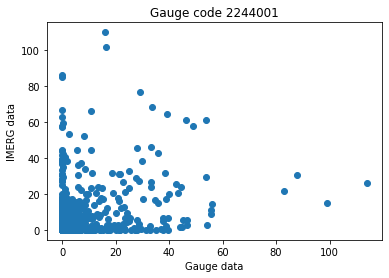

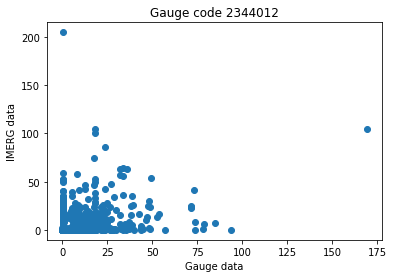

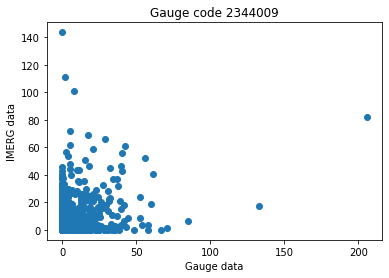

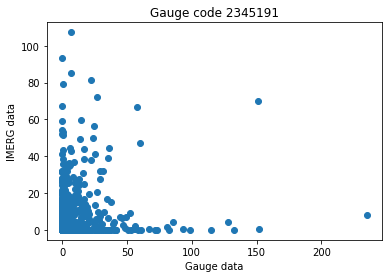

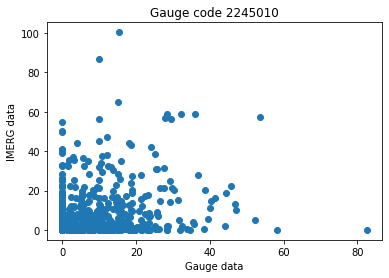

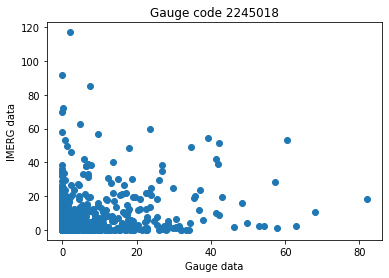

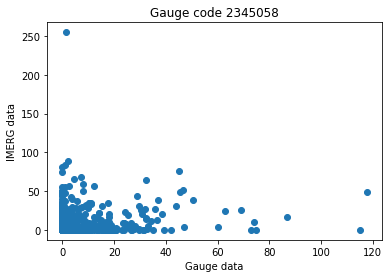

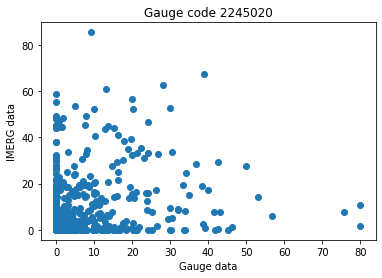

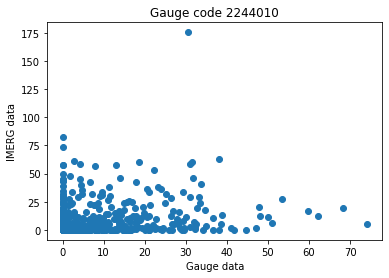

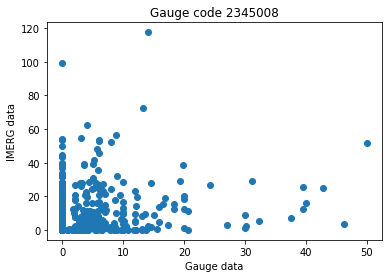

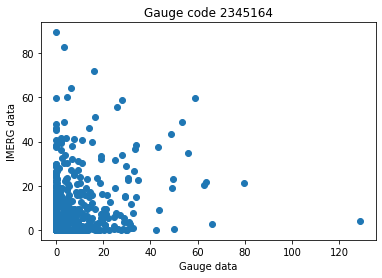

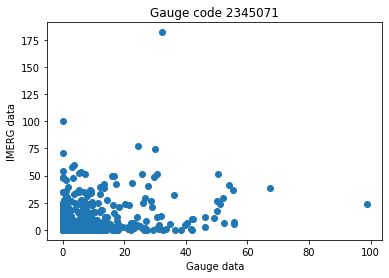

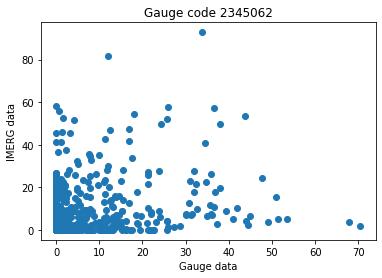

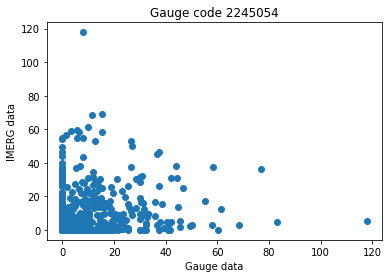

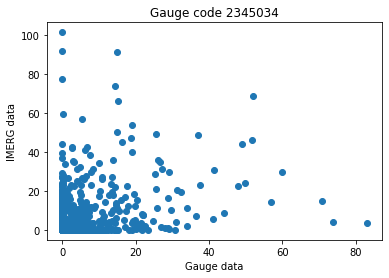

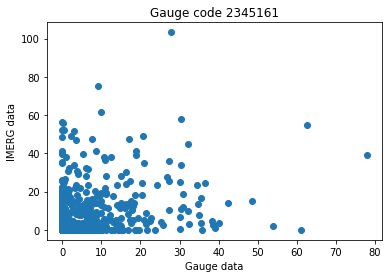

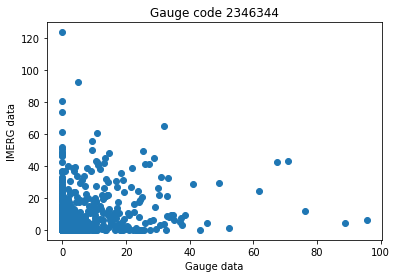

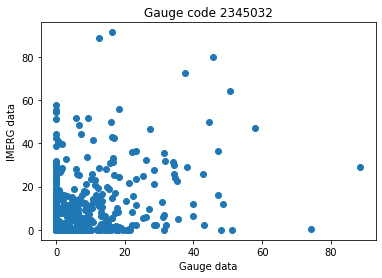

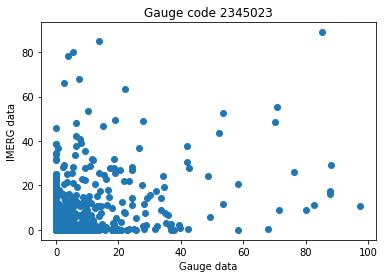

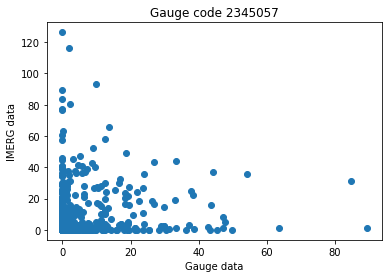

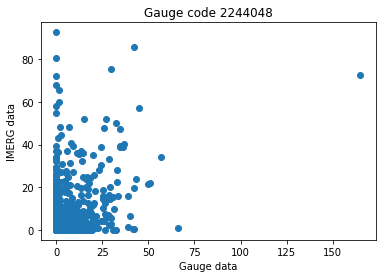

In [ ]:
# Plotting IMERG Scatter plot
# https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')
gauge = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauge = gauge.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
gauge.columns = gauge.columns.str[1:]
df = gauge.join(satelite, rsuffix='s')

df = gauge.join(satelite, rsuffix='s')

for c in codes:
  df[[c, c+'s']]
  df = df.dropna(axis=0, how='any')
  plot = plt.scatter(df[c], df[c+'s'])    #plt.scatter(x,y)
  plt.title('Gauge code '+c)
  plt.xlabel('Gauge data')
  plt.ylabel('IMERG data')
  plt.show(plot)

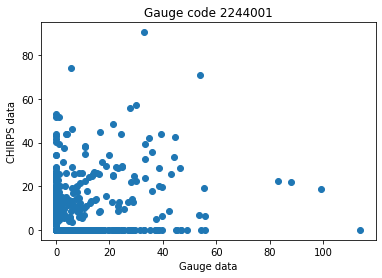

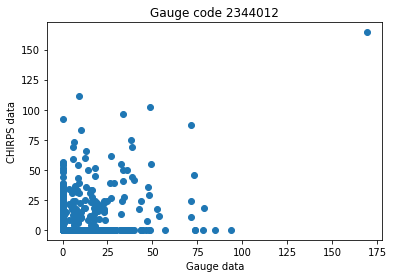

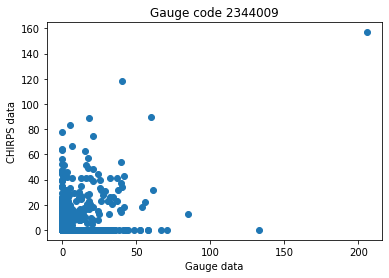

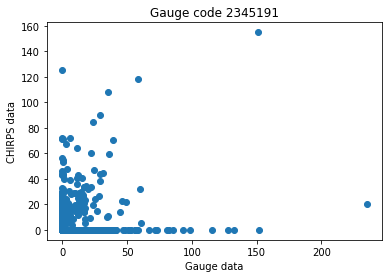

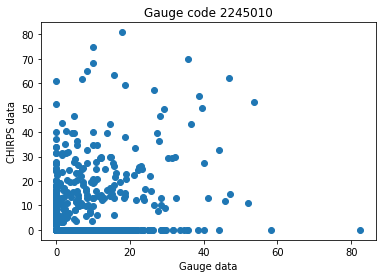

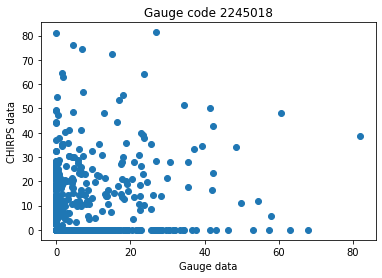

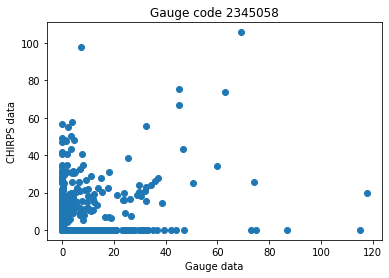

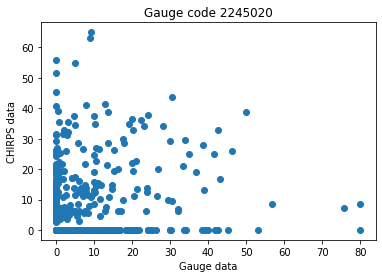

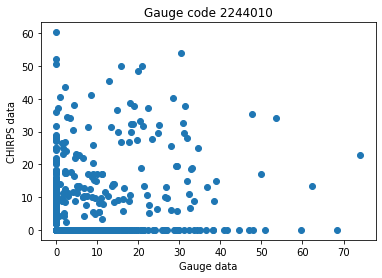

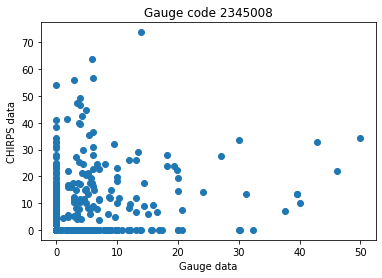

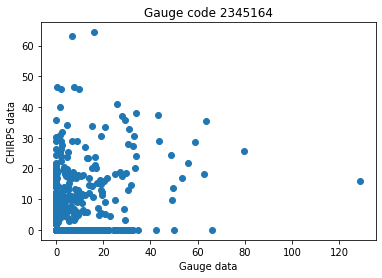

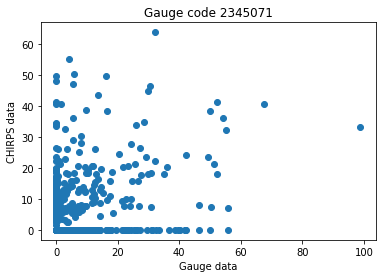

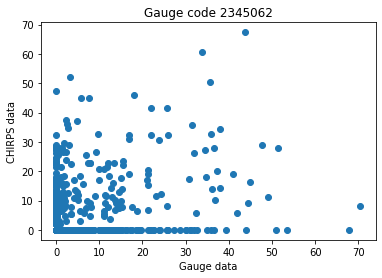

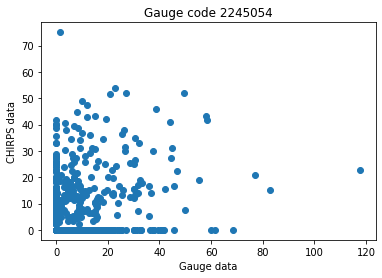

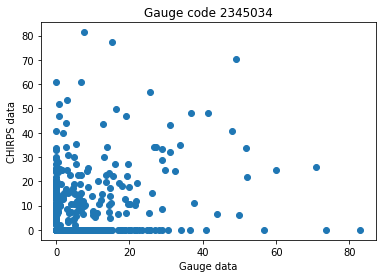

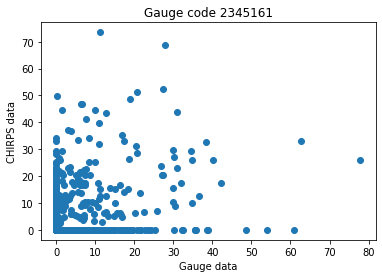

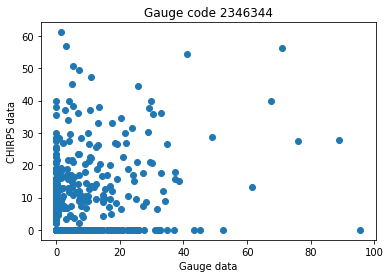

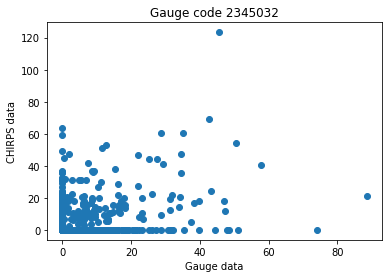

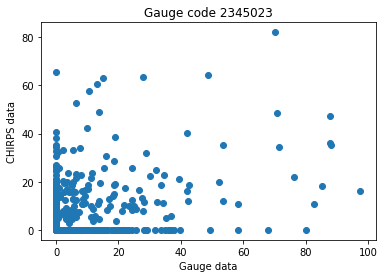

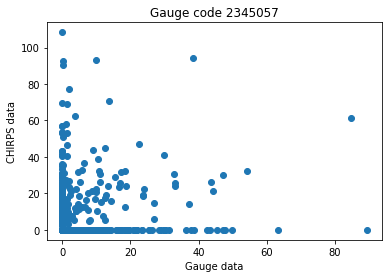

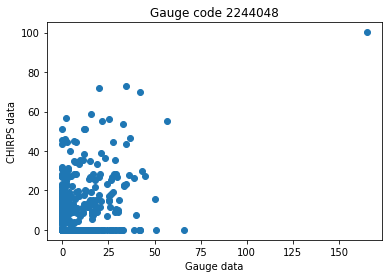

In [ ]:
# Plotting CHIRPS Scatter plot
# https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']


satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')

gauge = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauge = gauge.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
gauge.columns = gauge.columns.str[1:]
df = gauge.join(satelite, rsuffix='s')
df

for c in codes:
  df[[c, c+'s']]
  df = df.dropna(axis=0, how='any')
  plot = plt.scatter(df[c], df[c+'s'] )    #plt.scatter(x,y)
  plt.title('Gauge code '+c)
  plt.xlabel('Gauge data')
  plt.ylabel('CHIRPS data')
  plt.show(plot)